In [1]:
!pip install google-cloud-storage MedPy onedrivedownloader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.8/151.8 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 12.8 MB/s eta 0:00:00
  Created wheel for MedPy: filename=MedPy-0.4.0-py3-none-any.whl size=214946 sha256=190718c4ef468c5216158479659427de9e5357e4f36586326a6e7185535c95eb
  Stored in directory: /root/.cache/pip/wheels/d4/32/c7/6380ab2edb8cca018d39a0f1d43250fd9791922c963117de46
Successfully built MedPy


In [2]:
import os

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

working_dir = '/content/drive/My Drive/Capstone/BioCV_Su23/src'
os.chdir(working_dir)

Mounted at /content/drive


In [109]:
import importlib
import joblib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time

# Custom modules
import utils.data_handler as dh
import utils.mri_plotter as mrp
import utils.metrics as metrics

importlib.reload(dh)
importlib.reload(mrp)
importlib.reload(dh)


from utils.data_handler import DataHandler, StructuralScan, MriType
from utils.mri_plotter import MRIPlotter

#### INITALIZE VARIABLES

In [110]:
RECALCULATE = True
data_handler = DataHandler()

# mri_type_annotated = MriType.ANNOTATED
# mri_type_segmented = MriType.AUTO_SEGMENTED
# mri_type_struct = MriType.STRUCT_SCAN

# worst_dice_file_name = "worst_dice.joblib"
# worst_hd_file_name = "worst_hd95.joblib"
# scores_file = "variables.joblib"

mri_type_annotated = MriType.ANNOTATED_REDUCED
mri_type_segmented = MriType.AUTO_SEGMENTED_REDUCED
mri_type_struct = MriType.STRUCT_SCAN_REDUCED

worst_dice_file_name = "worst_dice-2.joblib"
worst_hd_file_name = "worst_hd95-2.joblib"
scores_file = "variables-2.joblib"

In [111]:
struct_files = data_handler.list_mri_in_dir(mri_type=mri_type_struct)

# if using reduce, make sure to include only those with _segm
annot_files = data_handler.list_mri_in_dir(mri_type=mri_type_annotated)
annot_files = [file for file in annot_files if "_segm" in file]

auto_segm_files = data_handler.list_mri_in_dir(mri_type=mri_type_segmented)

print("Struct Files", len(struct_files))
print("Annotated Files", len(annot_files))
print("Auto Segmented Files", len(auto_segm_files))

Struct Files 735
Annotated Files 147
Auto Segmented Files 147


### HELPER FUNCTIONS FOR PLOTTING

In [112]:
segment_ids = list(dh.SEGMENTS.keys())
segment_names = list(dh.SEGMENTS.values())

In [113]:
def get_nonzero_extents(arr):
  if not np.any(arr != 0):
    center = np.array(arr.shape) // 2
    minima = center - 1
    maxima = center + 1
    return minima, maxima
  else:
    indices = np.where(arr != 0)
    minima = np.min(indices, axis=1)
    maxima = np.max(indices, axis=1)
    return minima, maxima

def get_bounds(true_img_bin, pred_img_bin):
  min1, max1 = get_nonzero_extents(true_img_bin)
  min2, max2 = get_nonzero_extents(pred_img_bin)
  combined_min = np.minimum(min1, min2)
  combined_max = np.maximum(max1, max2)

  adj_min = np.maximum(combined_min-20, 0)
  adj_max = np.minimum(combined_max+20, np.array(true_img_bin.shape) - 1)
  return adj_min, adj_max

def convert_none_to_zero(img):
    converted_array = np.where(img==None, 0, img)
    return converted_array.astype(float)

def zoom_image(img, adj_min, adj_max):
  return img[adj_min[0]:adj_max[0]+1, adj_min[1]:adj_max[1]+1, :]

def plot_samples(subj_files_np, top_samples, hd95=False):
  nrows=len(top_samples)
  ncols=3

  mri_plt = MRIPlotter()
  fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(7*ncols, 6*nrows))

  for idx, img_info in enumerate(top_samples):

    subj_file_idx, segment_idx, hd95 = img_info

    subj_id = subj_files_np[subj_file_idx]
    segment_id = segment_ids[segment_idx]
    segment_name = segment_names[segment_idx]

    # load flair image as base image
    base_img = data_handler.load_mri(subj_id=subj_id,
                                mri_type=mri_type_struct,
                                struct_scan=StructuralScan.FLAIR)

    # load segmented and auto-segmented
    true_img = data_handler.load_mri(subj_id=subj_id,
                                mri_type=mri_type_annotated)
    pred_img = data_handler.load_mri(subj_id=subj_id,
                                mri_type=mri_type_segmented)

    # get binary mask for segment with lowest dice score
    true_img_bin = (true_img == segment_id)
    pred_img_bin = (pred_img == segment_id)

    # get appropriate slice from true image
    z_idx = data_handler.get_largest_tumor_slice_idx(true_img_bin)[0]

    if hd95 == True:
    # get all surface distance
      hd95, surface_dist_pred, surface_dist_true =  metrics.plot_hausdorff_95(pred_img, true_img, segment=segment_id)
      surface_dist_true_2 = convert_none_to_zero(surface_dist_true)

      # get appropriate slice from true image
      z_idx = data_handler.get_largest_tumor_slice_idx(surface_dist_true_2, sum=True)[0]


    # Column 1: plot base image FLAIR and predicted mask as overlay
    mri_plt.plot_struct_img(img_data=base_img, fig=fig, axs=axs, row=idx, col=0,
                            title=f"{subj_id} - Slice: {z_idx}", auto_cbar=False, slice_idx=z_idx)
    mri_plt.plot_segm_img(img_data=true_img, fig=fig, axs=axs, row=idx, col=0, overlay=True, slice_idx=z_idx)

    # Column 2: plot full mri scan with specific segment
    mri_plt.plot_struct_img(img_data=base_img, fig=fig, axs=axs, row=idx, col=1,
                            title=f"{subj_id}- {segment_name} - {round(hd95, 2)}",
                            auto_cbar=False, slice_idx=z_idx)
    mri_plt.plot_segm_img(img_data=true_img_bin, fig=fig, axs=axs, row=idx, col=1,
                          segm_cbar=False, overlay=True, cmap='Oranges', slice_idx=z_idx)
    mri_plt.plot_segm_img(img_data=pred_img_bin, fig=fig, axs=axs, row=idx, col=1,
                          segm_cbar=False, overlay=True, cmap="Greens", slice_idx=z_idx)

    # add legend
    orange = mpatches.Patch(color='red', label='annotated')
    green = mpatches.Patch(color='green', label='predicted')
    axs[idx, 1].legend(handles=[orange, green], loc='upper left')


    # Column 3: plot zoomed view
    adj_min, adj_max = get_bounds(true_img_bin, pred_img_bin)
    base_zoomed = zoom_image(base_img.copy(), adj_min, adj_max)
    true_zoomed = zoom_image(true_img_bin.copy(), adj_min, adj_max)
    pred_zoomed = zoom_image(pred_img_bin.copy(), adj_min, adj_max)

    mri_plt.plot_struct_img(img_data=base_zoomed, fig=fig, axs=axs, row=idx, col=2,
                            title=f"{subj_id} - {segment_name} - {round(hd95, 2)}",
                            auto_cbar=False, slice_idx=z_idx)
    mri_plt.plot_segm_img(img_data=true_zoomed, fig=fig, axs=axs, row=idx, col=2,
                          segm_cbar=False, overlay=True, cmap='Oranges', slice_idx=z_idx)
    mri_plt.plot_segm_img(img_data=pred_zoomed, fig=fig, axs=axs, row=idx, col=2,
                          segm_cbar=False, overlay=True, cmap="Greens", slice_idx=z_idx)

    axs[idx, 2].legend(handles=[orange, green], loc='upper left')
  plt.show()

### CALCULATE METRICS

In [114]:
def calc_metric_all_segments(segments, metric_func, *args, **kwargs):
  results = []
  for segment in segments:
    result = metric_func(*args, **kwargs, segm_id=segment)
    results.append(result)
  return results

In [115]:
all_common_metrics = []
all_dice = []
all_hd95 = []
all_missclass_per_label = []
all_true_per_label = []
error_files = []

In [116]:
# Calculate dice score one by one for each image to avoid out-of-memory issues
if RECALCULATE:
  start = time.time()

  subj_files = [annot_file.split("_")[0]+"_11" for annot_file in annot_files]
  for subj_id in subj_files:

    # load the segmented and auto segmented image of a file
    true_img = data_handler.load_mri(subj_id, mri_type=mri_type_annotated)
    pred_img = data_handler.load_mri(subj_id, mri_type=mri_type_segmented)
    try:
        print(f"Calculating metrics for {subj_id}")

        # metric 1: just count incorrect labels vs true labels for each file
        misclassified_per_label = []
        true_per_label = []
        for segment_id in segment_ids:
          true_count = np.sum(true_img == segment_id)
          pred_count = np.sum(pred_img == segment_id)

          count_difference = abs(true_count - pred_count)

          true_per_label.append(true_count)
          misclassified_per_label.append(count_difference)

        # metric 2: other common metrics
        common_metrics = calc_metric_all_segments(segment_ids, metrics.calc_binary_metrics, pred_img, true_img)
        common_metrics_dict = {}
        for key in common_metrics[0]:
            common_metrics_dict[key] = [metric[key] for metric in common_metrics]

        # metric 3: dice coefficient
        dice_score = calc_metric_all_segments(segment_ids, metrics.calc_dice_score, pred_img, true_img)

        # metric 4: 95% Hausdorff
        hausdorff_val =  calc_metric_all_segments(segment_ids, metrics.calc_hausdorff_95, pred_img, true_img)

        # append only when there is no error:
        all_dice.append(dice_score)
        all_hd95.append(hausdorff_val)
        all_missclass_per_label.append(misclassified_per_label)
        all_true_per_label.append(true_per_label)
        all_common_metrics.append(common_metrics_dict)
    except Exception as ex:
        print(f"Error {subj_id}", ex)
        error_files.append(subj_id)

  # remove error files from subj_files
  print("errors", error_files)
  subj_files = list(filter(lambda x: x not in error_files, subj_files))

  print(f"New length after removing problematic images: {len(subj_files)}")
  subj_files_np = np.array(subj_files)

  variables_dict = {'subj_files': subj_files,
                    'subj_files_np': subj_files_np,
                    'error_files': error_files,
                    'all_dice': all_dice,
                    'all_hd95': all_hd95,
                    'all_missclass_per_label': all_missclass_per_label,
                    'all_true_per_label': all_true_per_label,
                    'all_common_metrics': all_common_metrics}

  end = time.time()
  print("elapsed time", str(end - start))

  # Save locally via joblib. Running the entire calculation everytime takes time
  joblib.dump(variables_dict, os.path.join('training', scores_file))

Calculating metrics for UPENN-GBM-00002_11
Calculating metrics for UPENN-GBM-00006_11
Calculating metrics for UPENN-GBM-00008_11
Calculating metrics for UPENN-GBM-00009_11
Calculating metrics for UPENN-GBM-00011_11
Calculating metrics for UPENN-GBM-00013_11
Calculating metrics for UPENN-GBM-00014_11
Calculating metrics for UPENN-GBM-00016_11
Calculating metrics for UPENN-GBM-00017_11
Calculating metrics for UPENN-GBM-00018_11
Calculating metrics for UPENN-GBM-00020_11
Calculating metrics for UPENN-GBM-00021_11
Calculating metrics for UPENN-GBM-00026_11
Calculating metrics for UPENN-GBM-00029_11
Calculating metrics for UPENN-GBM-00030_11
Calculating metrics for UPENN-GBM-00031_11
Calculating metrics for UPENN-GBM-00033_11
Calculating metrics for UPENN-GBM-00035_11
Calculating metrics for UPENN-GBM-00040_11
Calculating metrics for UPENN-GBM-00041_11
Calculating metrics for UPENN-GBM-00043_11
Calculating metrics for UPENN-GBM-00054_11
Calculating metrics for UPENN-GBM-00059_11
Calculating

## RESULTS

In [117]:
# Read results from local repo to save time
if RECALCULATE == False:
  variables_dict = joblib.load(os.path.join('training', scores_file))
  subj_files = variables_dict["subj_files"]
  subj_files_np = variables_dict["subj_files_np"]
  error_files = variables_dict["error_files"]
  all_dice = variables_dict["all_dice"]
  all_hd95 = variables_dict["all_hd95"]
  all_missclass_per_label = variables_dict["all_missclass_per_label"]
  all_true_per_label = variables_dict["all_true_per_label"]
  all_common_metrics = variables_dict["all_common_metrics"]

### COUNT DIFFERENCE/ TRUE COUNT

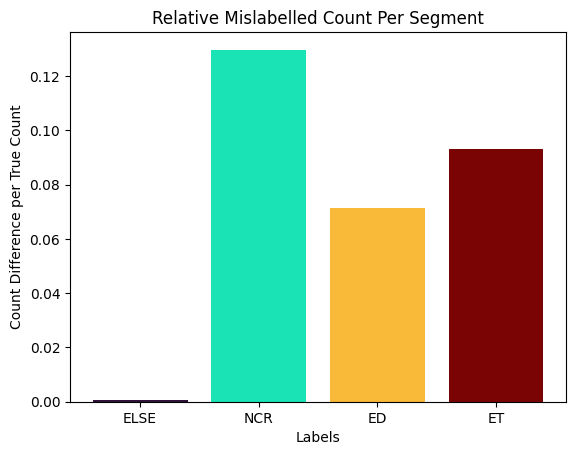

In [118]:
cmap = plt.get_cmap('turbo')
colors = cmap(np.linspace(0, 1, len(segment_ids)))

total_misclassifed = np.array(all_missclass_per_label).sum(axis = 0)
true_count = np.array(all_true_per_label).sum(axis = 0)
plt.bar(range(len(segment_ids)), total_misclassifed/true_count, color=colors)
plt.xlabel('Labels')
plt.ylabel('Count Difference per True Count')
plt.title('Relative Mislabelled Count Per Segment')
plt.xticks(range(len(segment_ids)), segment_names)
plt.show()

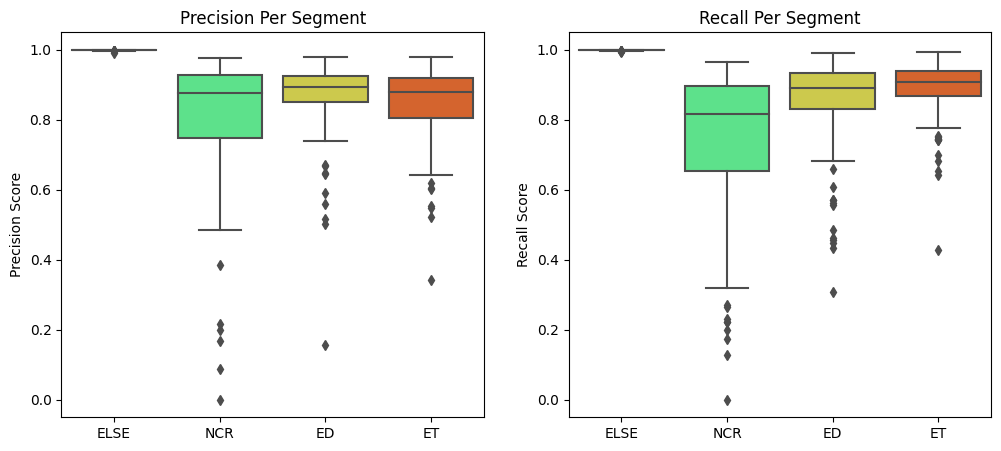

In [119]:
all_precision_np = np.array([metric['precision'] for metric in all_common_metrics])
all_recall_np = np.array([metric['recall'] for metric in all_common_metrics])

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

sns.boxplot(data=all_precision_np,  palette="turbo", ax=axs[0])
sns.boxplot(data=all_recall_np,  palette="turbo", ax=axs[1])

axs[0].set_xticks(range(len(segment_ids)), segment_names)
axs[0].set_ylabel("Precision Score")
axs[0].set_title("Precision Per Segment")
axs[1].set_xticks(range(len(segment_ids)), segment_names)
axs[1].set_ylabel("Recall Score")
axs[1].set_title("Recall Per Segment")

plt.show()

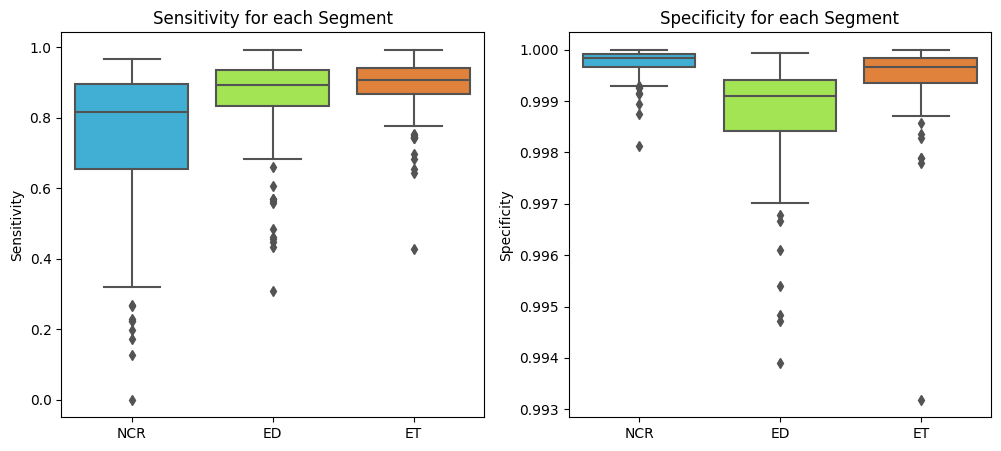

In [120]:
sensitivity_np = np.array([metric['sensitivity'] for metric in all_common_metrics])
specificity_np = np.array([metric['specificity'] for metric in all_common_metrics])

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

sns.boxplot(data=sensitivity_np[:, 1:],  palette="turbo", ax=axs[0])
sns.boxplot(data=specificity_np[:, 1:],  palette="turbo", ax=axs[1])


axs[0].set_xticks(range(len(segment_ids)-1), segment_names[1:])
axs[0].set_ylabel("Sensitivity")
axs[0].set_title("Sensitivity for each Segment")

axs[1].set_xticks(range(len(segment_ids)-1), segment_names[1:])
axs[1].set_ylabel("Specificity")
axs[1].set_title("Specificity for each Segment")

plt.show()

### DICE SCORE

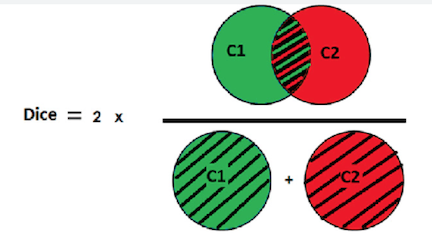

In [121]:
all_dice_np = np.array(all_dice)

In [122]:
dice_df = pd.DataFrame(all_dice_np, columns=segment_names)
dice_df.describe()[segment_names[1:]]

,NCR,ED,ET
count,146.000000,146.000000,146.000000
mean,0.759499,0.856041,0.864639
std,0.191194,0.108091,0.076197
min,0.000000,0.246763,0.496126
25%,0.692616,0.841408,0.836163
50%,0.820174,0.881181,0.880909
75%,0.893082,0.919323,0.908471
max,0.970380,0.963036,0.969159


#### DICE SCORE PER SEGMENT

ED has the lowest (LABEL 1)

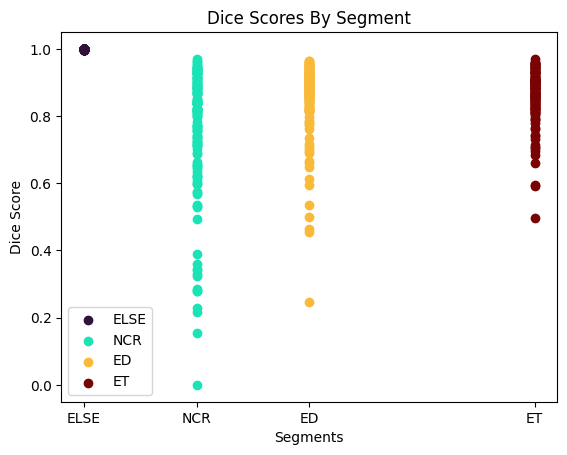

In [123]:
# Plot the dice scores as a scatter plot
cmap = plt.get_cmap('turbo')
colors = cmap(np.linspace(0, 1, len(segment_ids)))

for idx in range(len(segment_ids)):
  dice_scores = np.array(all_dice)[:, idx]
  label = segment_ids[idx]
  x_val = [label] * len(dice_scores)

  plt.scatter(x_val, dice_scores, label=f"{segment_names[idx]}", color=colors[idx])
  plt.xlabel('Segments')
  plt.ylabel('Dice Score')
  plt.title('Dice Scores By Segment')
  plt.legend()

plt.xticks(segment_ids, segment_names)
plt.show()

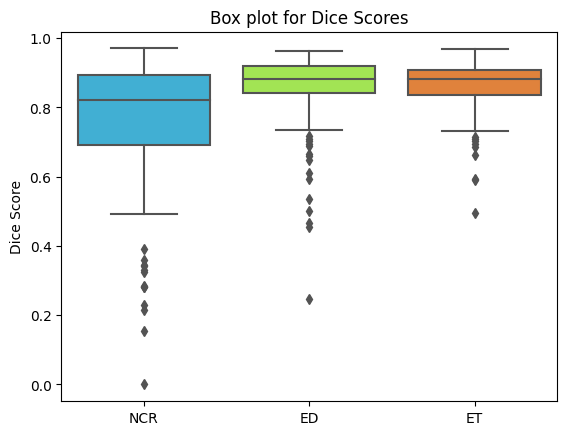

In [124]:
### Statistics
sns.boxplot(data=all_dice_np[:, 1:],  palette="turbo")
plt.xticks(range(len(segment_ids)-1), segment_names[1:])
plt.ylabel("Dice Score")
plt.title("Box plot for Dice Scores")
plt.show()

#### DICE SCORE FOR EACH FILE

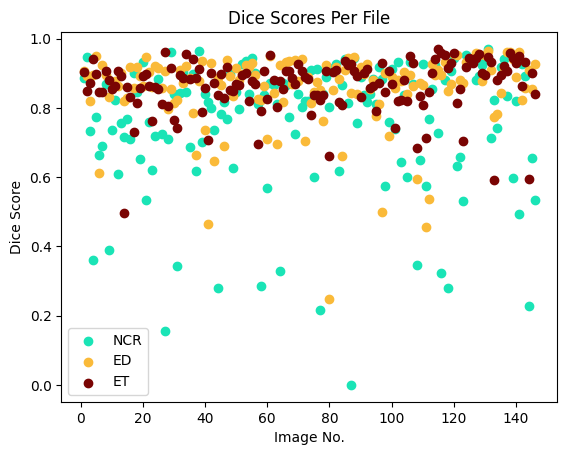

In [125]:
cmap = plt.get_cmap('turbo')
colors = cmap(np.linspace(0, 1, len(segment_ids)))

scores_len = len(all_dice)

for segm_idx in range(1, len(segment_ids)):
  dice_scores = all_dice_np[:, segm_idx]
  plt.scatter(np.arange(1, scores_len+1), dice_scores, color=colors[segm_idx], label=f"{segment_names[segm_idx]}")

plt.xlabel('Image No.')
plt.ylabel('Dice Score')
plt.title('Dice Scores Per File')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.legend()
plt.show()

#### DICE SCORE HISTOGRAM

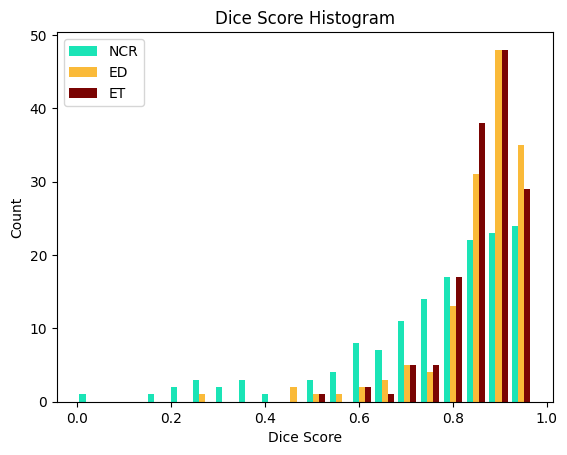

In [126]:
# Make a separate list for each segment
x2 = all_dice_np[:, 1]
x3 = all_dice_np[:, 2]
x4 = all_dice_np[:, 3]

# Assign colors for each segment and the names
cmap = plt.get_cmap('turbo')
colors = cmap(np.linspace(0, 1, len(segment_ids)))
names = segment_names

plt.hist([x2, x3, x4], bins = 20, color = colors[1:], label=names[1:])
plt.legend()
plt.xlabel('Dice Score')
plt.ylabel('Count')
plt.title('Dice Score Histogram')
plt.show()

#### PLOT IMAGES WITH THE LOWEST DICE SCORES

In [127]:
# Flatten the array
flattened_array = all_dice_np.flatten()

# rearranges the elements such that the smallest 10 elements come before the 10th index
top_10_idx_1d = np.argpartition(flattened_array, kth=10)[:10]

# Reshape the indices back to the original 2D shape to get row (file number) and col (segment)
top_10_indices = np.unravel_index(top_10_idx_1d, all_dice_np.shape)

top_10_values = all_dice_np[top_10_indices]
top_10_worst_dice = list(zip(top_10_indices[0], top_10_indices[1], top_10_values))
top_10_worst_dice_sorted = sorted(top_10_worst_dice, key=lambda x: x[2])

In [128]:
plot_samples(subj_files_np, top_10_worst_dice_sorted)

Output hidden; open in https://colab.research.google.com to view.

### HAUSDORFF DISTANCE

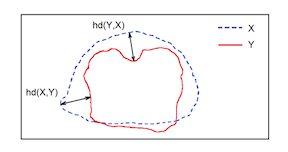

In [129]:
# replace None values with highest hd95
max_value = 0
none_indices = []
for subj_idx, hd95_per_subj in enumerate(all_hd95):
  for segm_idx, hd95 in enumerate(hd95_per_subj):
    if hd95 is None or hd95 == np.inf:
      none_indices.append((subj_idx, segm_idx))
    else:
      if hd95 > max_value:
        max_value = hd95

print("max hausdorff", str(max_value))
print(none_indices)

max hausdorff 19.712929453234015
[(86, 1)]


In [130]:
for row, col in none_indices:
  all_hd95[row][col] = max_value + 1

In [131]:
all_hd95_np = np.array(all_hd95)
hd95_df = pd.DataFrame(all_hd95_np, columns=segment_names).astype(float)
hd95_df.isnull().sum()

ELSE    0
NCR     0
ED      0
ET      0
dtype: int64

In [132]:
hd95_df.describe()[segment_names[1:]]

,NCR,ED,ET
count,146.000000,146.000000,146.000000
mean,2.845788,2.565015,1.424394
std,2.935253,2.625237,1.762371
min,1.000000,1.000000,1.000000
25%,1.414214,1.414214,1.000000
50%,2.236068,1.732051,1.000000
75%,3.162278,2.733693,1.000000
max,20.712929,17.029386,18.248267


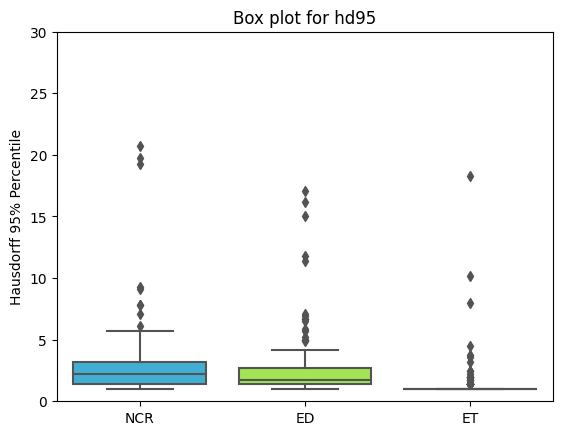

In [133]:
### Statistics
sns.boxplot(data=all_hd95_np[:,1:], palette="turbo")
plt.xticks(range(len(segment_ids)-1), segment_names[1:])
plt.ylabel("Hausdorff 95% Percentile")
plt.title("Box plot for hd95")
plt.ylim(0, 30)
plt.show()

#### HAUSDORFF DISTANCES PER SEGMENT

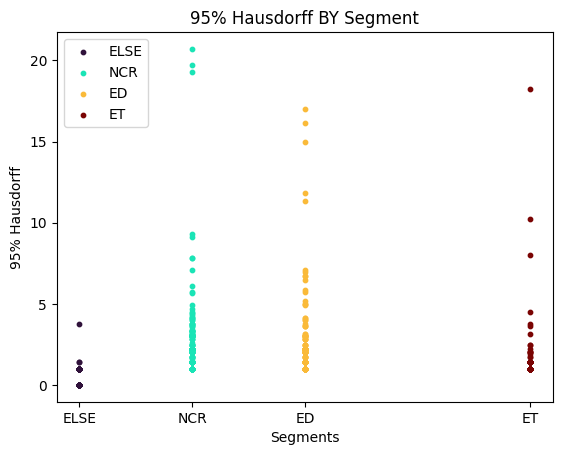

In [134]:
# Plot hausdorff scores as a scatter plot
cmap = plt.get_cmap('turbo')
colors = cmap(np.linspace(0, 1, len(segment_ids)))

for idx in range(len(segment_ids)):
  y_val = all_hd95_np[:, idx]
  label = segment_ids[idx]
  x_val = [label] * len(y_val)

  plt.scatter(x_val, y_val, label=f"{segment_names[idx]}", color=colors[idx], s=10)
  plt.xlabel('Segments')
  plt.ylabel('95% Hausdorff')
  plt.title('95% Hausdorff BY Segment')
  plt.legend()

plt.xticks(segment_ids, segment_names)
plt.show()

#### HAUSDORFF DISTANCES PER FILE

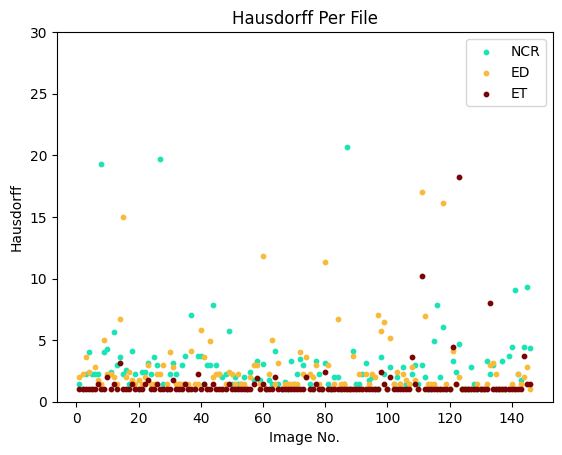

In [135]:
cmap = plt.get_cmap('turbo')
colors = cmap(np.linspace(0, 1, len(segment_ids)))

scores_len = len(all_hd95)

for segm_idx in range(1, len(segment_ids)):
  dice_scores = all_hd95_np[:, segm_idx]
  plt.scatter(np.arange(1, scores_len+1), dice_scores, color=colors[segm_idx],
              label=f"{segment_names[segm_idx]}", s=10)

plt.xlabel('Image No.')
plt.ylabel('Hausdorff')
plt.title('Hausdorff Per File')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# hide outlier
plt.ylim(0, 30)

plt.legend()
plt.show()

#### HAUSDORFF HISTOGRAM

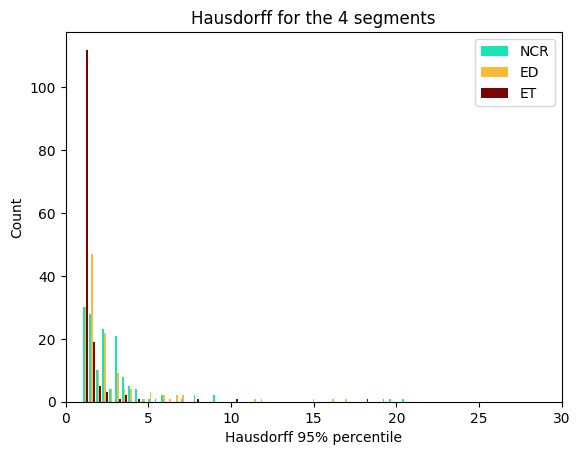

In [136]:
# Make a separate list for each segment
x2 = all_hd95_np[:, 1]
x3 = all_hd95_np[:, 2]
x4 = all_hd95_np[:, 3]

# Assign colors for each airline and the names
cmap = plt.get_cmap('turbo')
colors = cmap(np.linspace(0, 1, len(segment_ids)))
names = segment_names

plt.hist([x2, x3, x4], bins = 50, color = colors[1:], label=names[1:])
plt.legend()
plt.xlim(0, 30)
plt.xlabel('Hausdorff 95% percentile')
plt.ylabel('Count')
plt.title('Hausdorff for the 4 segments')
plt.show()

#### PLOT IMAGES WITH HIGHEST HD95 SCORE

In [137]:
# Get 10 images with lowest hausdorff distance
# Flatten the array
flattened_array = all_hd95_np.flatten()

# Find the indices of the top 10 largest numbers
top_10_idx_1d = np.argpartition(flattened_array, kth=-10)[-10:]

# Reshape the indices back to the original 2D shape
top_10_indices = np.unravel_index(top_10_idx_1d, all_hd95_np.shape)
top_10_values = all_hd95_np[top_10_indices]
top_10_worst_hd = list(zip(top_10_indices[0], top_10_indices[1], top_10_values))
top_10_worst_hd_sorted = sorted(top_10_worst_hd, key=lambda x: -x[2])

In [138]:
plot_samples(subj_files_np, top_10_worst_hd_sorted)

Output hidden; open in https://colab.research.google.com to view.

### SAVE RESULTS

In [139]:
# Save to file
worst_dice_subj_idx = list(zip(*top_10_worst_dice_sorted))[0]
worst_dice_subj_names = subj_files_np[list(worst_dice_subj_idx)]
top_10_worst_dice_sorted_dict = []
for idx, subj in enumerate(worst_dice_subj_names):
  subj_idx, segm, score = top_10_worst_dice_sorted[idx]
  top_10_worst_dice_sorted_dict.append(
      {
          "subj": subj,
          "label": segm,
          "score": score
      }
  )
top_10_worst_dice_sorted_dict

[{'subj': 'UPENN-GBM-00201_11', 'label': 1, 'score': 0.0},
 {'subj': 'UPENN-GBM-00069_11', 'label': 1, 'score': 0.15544041450777202},
 {'subj': 'UPENN-GBM-00173_11', 'label': 1, 'score': 0.21587743732590528},
 {'subj': 'UPENN-GBM-00438_11', 'label': 1, 'score': 0.22878228782287824},
 {'subj': 'UPENN-GBM-00178_11', 'label': 2, 'score': 0.24676313785224677},
 {'subj': 'UPENN-GBM-00307_11', 'label': 1, 'score': 0.28013029315960913},
 {'subj': 'UPENN-GBM-00107_11', 'label': 1, 'score': 0.2804938271604938},
 {'subj': 'UPENN-GBM-00135_11', 'label': 1, 'score': 0.2851153039832285},
 {'subj': 'UPENN-GBM-00290_11', 'label': 1, 'score': 0.3240506329113924},
 {'subj': 'UPENN-GBM-00141_11', 'label': 1, 'score': 0.32926233512457254}]

In [140]:
worst_hd_subj_idx = list(zip(*top_10_worst_hd_sorted))[0]
worst_hd_subj_names = subj_files_np[list(worst_hd_subj_idx)]
top_10_worst_hd_sorted_dict = []
for idx, subj in enumerate(worst_hd_subj_names):
  subj_idx, segm, score = top_10_worst_hd_sorted[idx]
  top_10_worst_hd_sorted_dict.append(
      {
          "subj": subj,
          "label": segm,
          "score": score
      }
  )
top_10_worst_hd_sorted_dict

[{'subj': 'UPENN-GBM-00201_11', 'label': 1, 'score': 20.712929453234015},
 {'subj': 'UPENN-GBM-00069_11', 'label': 1, 'score': 19.712929453234015},
 {'subj': 'UPENN-GBM-00016_11', 'label': 1, 'score': 19.261360284258224},
 {'subj': 'UPENN-GBM-00356_11', 'label': 3, 'score': 18.24826702039283},
 {'subj': 'UPENN-GBM-00274_11', 'label': 2, 'score': 17.029386365926403},
 {'subj': 'UPENN-GBM-00307_11', 'label': 2, 'score': 16.147749690201906},
 {'subj': 'UPENN-GBM-00030_11', 'label': 2, 'score': 15.0},
 {'subj': 'UPENN-GBM-00137_11', 'label': 2, 'score': 11.832159566199232},
 {'subj': 'UPENN-GBM-00178_11', 'label': 2, 'score': 11.357816691600547},
 {'subj': 'UPENN-GBM-00274_11', 'label': 3, 'score': 10.198039027185569}]

In [141]:
# Create temp files
worst_dice_temp_file = data_handler.create_temp_file(worst_dice_file_name)
print(worst_dice_temp_file)

worst_hd95_temp_file = data_handler.create_temp_file(worst_hd_file_name)
print(worst_hd95_temp_file)

/tmp/tmp5pddwjec.joblib
/tmp/tmpb40w1ht9.joblib


In [142]:
# dump data into the temp files
joblib.dump(top_10_worst_dice_sorted_dict, worst_dice_temp_file)
joblib.dump(top_10_worst_hd_sorted_dict, worst_hd95_temp_file)

['/tmp/tmpb40w1ht9.joblib']

In [143]:
# save to cloud
data_handler.save_from_source_path(file_name=worst_dice_file_name, source_path=worst_dice_temp_file,
                                   train_dir_prefix="metrics", use_cloud=True)
data_handler.save_from_source_path(file_name=worst_hd_file_name, source_path=worst_hd95_temp_file,
                                   train_dir_prefix="metrics", use_cloud=True)

### COMPARE SCORES BETWEEN ORIGINAL AND REDUCED

verified that the scores are the same with original vs reduced

In [144]:
worst_dice_original_fname = data_handler.load_to_temp_file(file_name="worst_dice.joblib", train_dir_prefix="metrics")
worst_dice_reduced_fname = data_handler.load_to_temp_file(file_name="worst_dice-2.joblib", train_dir_prefix="metrics")

worst_hd_original_fname = data_handler.load_to_temp_file(file_name="worst_hd95.joblib", train_dir_prefix="metrics")
worst_hd_reduced_fname = data_handler.load_to_temp_file(file_name="worst_hd95-2.joblib", train_dir_prefix="metrics")

In [145]:
# load from temp files:
worst_dice_original = joblib.load(worst_dice_original_fname)
worst_dice_original

[{'subj': 'UPENN-GBM-00201_11', 'label': 1, 'score': 0.0},
 {'subj': 'UPENN-GBM-00069_11', 'label': 1, 'score': 0.15544041450777202},
 {'subj': 'UPENN-GBM-00173_11', 'label': 1, 'score': 0.21587743732590528},
 {'subj': 'UPENN-GBM-00438_11', 'label': 1, 'score': 0.22878228782287824},
 {'subj': 'UPENN-GBM-00178_11', 'label': 2, 'score': 0.24676313785224677},
 {'subj': 'UPENN-GBM-00307_11', 'label': 1, 'score': 0.28013029315960913},
 {'subj': 'UPENN-GBM-00107_11', 'label': 1, 'score': 0.2804938271604938},
 {'subj': 'UPENN-GBM-00135_11', 'label': 1, 'score': 0.2851153039832285},
 {'subj': 'UPENN-GBM-00290_11', 'label': 1, 'score': 0.3240506329113924},
 {'subj': 'UPENN-GBM-00141_11', 'label': 1, 'score': 0.32926233512457254}]

In [146]:
worst_dice_reduced = joblib.load(worst_dice_reduced_fname)
worst_dice_reduced

[{'subj': 'UPENN-GBM-00201_11', 'label': 1, 'score': 0.0},
 {'subj': 'UPENN-GBM-00069_11', 'label': 1, 'score': 0.15544041450777202},
 {'subj': 'UPENN-GBM-00173_11', 'label': 1, 'score': 0.21587743732590528},
 {'subj': 'UPENN-GBM-00438_11', 'label': 1, 'score': 0.22878228782287824},
 {'subj': 'UPENN-GBM-00178_11', 'label': 2, 'score': 0.24676313785224677},
 {'subj': 'UPENN-GBM-00307_11', 'label': 1, 'score': 0.28013029315960913},
 {'subj': 'UPENN-GBM-00107_11', 'label': 1, 'score': 0.2804938271604938},
 {'subj': 'UPENN-GBM-00135_11', 'label': 1, 'score': 0.2851153039832285},
 {'subj': 'UPENN-GBM-00290_11', 'label': 1, 'score': 0.3240506329113924},
 {'subj': 'UPENN-GBM-00141_11', 'label': 1, 'score': 0.32926233512457254}]

In [147]:
worst_hd_original = joblib.load(worst_hd_original_fname)
worst_hd_original

[{'subj': 'UPENN-GBM-00201_11', 'label': 1, 'score': 20.712929453234015},
 {'subj': 'UPENN-GBM-00069_11', 'label': 1, 'score': 19.712929453234015},
 {'subj': 'UPENN-GBM-00016_11', 'label': 1, 'score': 19.261360284258224},
 {'subj': 'UPENN-GBM-00356_11', 'label': 3, 'score': 18.24826702039283},
 {'subj': 'UPENN-GBM-00274_11', 'label': 2, 'score': 17.029386365926403},
 {'subj': 'UPENN-GBM-00307_11', 'label': 2, 'score': 16.147749690201906},
 {'subj': 'UPENN-GBM-00030_11', 'label': 2, 'score': 15.0},
 {'subj': 'UPENN-GBM-00137_11', 'label': 2, 'score': 11.832159566199232},
 {'subj': 'UPENN-GBM-00178_11', 'label': 2, 'score': 11.357816691600547},
 {'subj': 'UPENN-GBM-00274_11', 'label': 3, 'score': 10.198039027185569}]

In [148]:
worst_hd_reduced = joblib.load(worst_hd_reduced_fname)
worst_hd_reduced

[{'subj': 'UPENN-GBM-00201_11', 'label': 1, 'score': 20.712929453234015},
 {'subj': 'UPENN-GBM-00069_11', 'label': 1, 'score': 19.712929453234015},
 {'subj': 'UPENN-GBM-00016_11', 'label': 1, 'score': 19.261360284258224},
 {'subj': 'UPENN-GBM-00356_11', 'label': 3, 'score': 18.24826702039283},
 {'subj': 'UPENN-GBM-00274_11', 'label': 2, 'score': 17.029386365926403},
 {'subj': 'UPENN-GBM-00307_11', 'label': 2, 'score': 16.147749690201906},
 {'subj': 'UPENN-GBM-00030_11', 'label': 2, 'score': 15.0},
 {'subj': 'UPENN-GBM-00137_11', 'label': 2, 'score': 11.832159566199232},
 {'subj': 'UPENN-GBM-00178_11', 'label': 2, 'score': 11.357816691600547},
 {'subj': 'UPENN-GBM-00274_11', 'label': 3, 'score': 10.198039027185569}]

In [149]:
# nrows=len(top_10_worst_hd_sorted)
# ncols=3

# mri_plt = MRIPlotter()
# fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(7*ncols, 6*nrows))

# for idx, img_info in enumerate(top_10_worst_hd_sorted):

#   subj_file_idx, segment_idx, hd95 = img_info
#   subj_id = subj_files_np[subj_file_idx]
#   segment = segment_ids[segment_idx]
#   segment_name = segment_names[segment_idx]

#   # load flair image as base image
#   base_img = data_handler.load_mri(subj_id=subj_id,
#                                 mri_type=MriType.STRUCT_SCAN,
#                                 struct_scan=StructuralScan.FLAIR)

#   # load segmented and auto-segmented
#   true_img = data_handler.load_mri(subj_id=subj_id, mri_type=MriType.ANNOTATED)
#   pred_img = data_handler.load_mri(subj_id=subj_id, mri_type=MriType.AUTO_SEGMENTED)

#   # get binary mask for segment with lowest dice score
#   true_img_bin = (true_img == segment)
#   pred_img_bin = (pred_img == segment)

#   # get all surface distance
#   hd95, surface_dist_pred, surface_dist_true =  metrics.plot_hausdorff_95(pred_img, true_img, segm_id=segment)
#   surface_dist_pred_2 = convert_none_to_zero(surface_dist_pred)
#   surface_dist_true_2 = convert_none_to_zero(surface_dist_true)

#   # get appropriate slice from true image
#   z_idx = data_handler.get_largest_tumor_slice_idx(surface_dist_true_2, sum=True)[0]

#   # column 1 plot base image FLAIR and predicted mask
#   mri_plt.plot_struct_img(img_data=base_img, fig=fig, axs=axs, row=idx, col=0,
#                           title=f"{subj_id} - HD95: {round(hd95, 2)}", auto_cbar=False, slice_idx=z_idx)
#   mri_plt.plot_segm_img(img_data=true_img, fig=fig, axs=axs, row=idx, col=0, overlay=True, slice_idx=z_idx)


#   # column 2
#   mri_plt.plot_img(img_data=surface_dist_true_2, fig=fig, axs=axs, row=idx,
#                    col=1, title=f"Annotated - Surface Distance - {segment_name} - Slice {z_idx}", slice_idx=z_idx, cmap="cividis")

#   # column 3
#   z_idx_pred = data_handler.get_largest_tumor_slice_idx(surface_dist_pred_2, sum=True)[0]
#   mri_plt.plot_img(img_data=surface_dist_pred_2, fig=fig, axs=axs, row=idx,
#                    col=2, title=f"Predicted - Surface Distance - {segment_name} - Slice {z_idx_pred}", slice_idx=z_idx_pred, cmap="cividis")

# plt.show()